In [0]:
# http://pytorch.org/
from os.path import exists
from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())
cuda_output = !ldconfig -p|grep cudart.so|sed -e 's/.*\.\([0-9]*\)\.\([0-9]*\)$/cu\1\2/'
accelerator = cuda_output[0] if exists('/dev/nvidia0') else 'cpu'

!pip install -q http://download.pytorch.org/whl/{accelerator}/torch-0.4.1-{platform}-linux_x86_64.whl torchvision
import torch

tcmalloc: large alloc 1073750016 bytes == 0x562634048000 @  0x7f10fe3c82a4 0x5625dcc71f18 0x5625dcd65a85 0x5625dcc854ca 0x5625dcc8a232 0x5625dcc82d0a 0x5625dcc8a5fe 0x5625dcc82d0a 0x5625dcc8a5fe 0x5625dcc82d0a 0x5625dcc8a5fe 0x5625dcc82d0a 0x5625dcc8ac38 0x5625dcc82d0a 0x5625dcc8a5fe 0x5625dcc82d0a 0x5625dcc8a5fe 0x5625dcc8a232 0x5625dcc8a232 0x5625dcc82d0a 0x5625dcc8ac38 0x5625dcc8a232 0x5625dcc82d0a 0x5625dcc8ac38 0x5625dcc82d0a 0x5625dcc8ac38 0x5625dcc82d0a 0x5625dcc8a5fe 0x5625dcc82d0a 0x5625dcc82629 0x5625dccb361f


In [0]:
import torch
import torch.nn as nn
import torch.utils as utils
from torch.autograd import Variable
import torchvision.datasets as dsets
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import os
%matplotlib inline

In [0]:
# Hyperparameters

epochs = 10
batch_size =100
learning_rate = 0.001

# Loading the Dataset

train_dataset = dsets.CIFAR10(root='./data', 
                            train=True, 
                            transform=transforms.ToTensor(),
                            download=True)
 
test_dataset = dsets.CIFAR10(root='./data', 
                           train=False, 
                           transform=transforms.ToTensor())



train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=batch_size, 
                                           shuffle=True)
 
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, 
                                          batch_size=batch_size, 
                                          shuffle=False)


Files already downloaded and verified


In [0]:
# Encoder 

class Encoder(nn.Module):
    def __init__(self):
        super(Encoder,self).__init__()
        self.layer1 = nn.Sequential(
            # batch x 32 x 30 x 30
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=1, padding=0), 
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.Conv2d(32,32,3,padding=0),  
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.Conv2d(32,64,3,padding=0),  
            nn.ReLU()
            )
        self.layer2 = nn.Sequential(
            
            nn.Conv2d(64,64,3,padding=0),  
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.Conv2d(64,128,3,padding=0),  
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.Conv2d(128,128,3,padding=0),  
            nn.ReLU()
            
        )
                   
    def forward(self,x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.view(batch_size, -1)
        return out
    
encoder = Encoder().cuda().float()

In [0]:
# Decoder

class Decoder(nn.Module):
    def __init__(self):
        super(Decoder,self).__init__()
        self.layer1 = nn.Sequential(
                        nn.ConvTranspose2d(128,128,3,1,0),
                        nn.ReLU(),
                        nn.BatchNorm2d(128),
                        nn.ConvTranspose2d(128,64,3,1,0),
                        nn.ReLU(),
                        nn.BatchNorm2d(64),
                        nn.ConvTranspose2d(64,64,3,1,0),
                        nn.ReLU(),
        )
        self.layer2 = nn.Sequential(
                        nn.ConvTranspose2d(64,32,3,1,0),
                        nn.ReLU(),
                        nn.BatchNorm2d(32),
                        nn.ConvTranspose2d(32,32,3,1,0),
                        nn.ReLU(),
                        nn.BatchNorm2d(32),
                        nn.ConvTranspose2d(32,3,3,1,0,0),
                        nn.ReLU()
        )
        
    def forward(self,x):
        out = x.view(batch_size,128,20,20)
        out = self.layer1(out)
        out = self.layer2(out)
        return out

decoder = Decoder().cuda().float()

In [0]:
# Loss function and Optimizer

parameters = list(encoder.parameters())+ list(decoder.parameters())
loss_func = nn.MSELoss()
optimizer = torch.optim.Adam(parameters, lr=learning_rate)

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
# Training Encoder and Decoder

if not os.path.exists('./model'):
    os.mkdir('./model')
try:
    encoder, decoder = torch.load('./model/deno_autoencoder.pkl')
    print("\n--------model restored--------\n")
except:
    print("\n--------model not restored--------\n")
    pass

for i in range(epochs):
    for image,label in train_loader:
      
        image_n = torch.mul(image+0.25, 0.1 * torch.rand(batch_size,3,32,32))
        image = Variable(image).cuda()
        image_n = Variable(image_n).cuda()
                
        optimizer.zero_grad()
        output = encoder(image_n)
        output = decoder(output)
        
        loss = loss_func(output,image)
        loss.backward()
        optimizer.step()
        
    print('epoch [{}/{}], loss:{:.4f}'
          .format(i + 1, epochs, loss.data[0]))       
                
torch.save([encoder,decoder],'./model/deno_autoencoder.pkl')
print(loss)


--------model restored--------



/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:28: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


epoch [1/10], loss:0.0097
epoch [2/10], loss:0.0082
epoch [3/10], loss:0.0094
epoch [4/10], loss:0.0098
epoch [5/10], loss:0.0093
epoch [6/10], loss:0.0094
epoch [7/10], loss:0.0087
epoch [8/10], loss:0.0092
epoch [9/10], loss:0.0087
epoch [10/10], loss:0.0109
tensor(0.0109, device='cuda:0', grad_fn=<MseLossBackward>)


In [0]:
def plot_images(tensor, n_cols=30):
  n_kernels = tensor.shape[0]
  n_rows = 1+ n_kernels // n_cols
  fig = plt.figure(figsize=(n_cols,n_rows))
  for i in range(n_kernels):
    ax1 = fig.add_subplot(n_rows,n_cols,i+1)
    ax1.imshow(tensor[i], cmap='gray')
    ax1.axis('off')
    ax1.set_xticklabels([])
    ax1.set_yticklabels([])
    
  plt.subplots_adjust(wspace=1, hspace=1)
  plt.show()

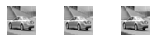

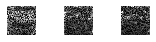

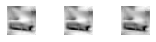

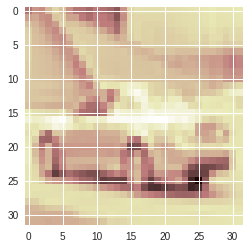

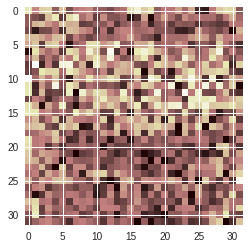

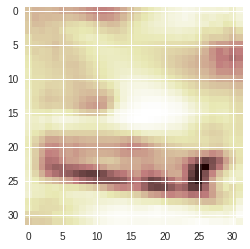

tensor(1)


In [0]:
# Output of Convolutional AutoEncoder
# Plotting original image, image with noise and denoised image

img = image[0].cpu()
input_img = image_n[0].cpu()
output_img = output[0].cpu()

origin = img.data.numpy()
inp = input_img.data.numpy()
out = output_img.data.numpy()

plot_images(origin)
plot_images(inp)
plot_images(out)

plt.imshow(origin[0], cmap='pink')
plt.show()

plt.imshow(inp[0], cmap='pink')
plt.show()

plt.imshow(out[0], cmap='pink')
plt.show()

print(label[0])